In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
## Construction related data collected from the Australian Bureau of Statistics
CONSTRUCTION_INPUTS = "../data/Input Prices for Constructions.xlsx"
CONSTRUCTION_OUTPUTS = "../data/Output Prices from Constructions.xlsx"
CONSTRUCTION_WORKS = "../data/Value of Construction Works.xlsx"
LOAN_COMMITMENTS = "../data/Loan Commitment.xlsx"

## Key variables for illiquid stock analysis
FRED = "FEDFUNDS"
ILLIQUID_TICKER = "KELYB"
LIQUID_INDEX_TICKER = "SPY"
VOLATILITY_TRACKER = "^VIX"

In [3]:
## CODE from M1 Lesson 1 of FD

def get_fred_data(param_list, start_date, end_date) -> pd.DataFrame:
    df = pdr.DataReader(param_list, "fred", start_date, end_date) 
    return df.reset_index()

In [4]:
c_inputs = pd.read_excel(CONSTRUCTION_INPUTS, sheet_name='Data1')
c_outputs = pd.read_excel(CONSTRUCTION_OUTPUTS, sheet_name='Data1')
c_works = pd.read_excel(CONSTRUCTION_WORKS, sheet_name='Data1')
c_commit = pd.read_excel(LOAN_COMMITMENTS, sheet_name='Data1')

## Data Analysis for Construction Loan

### Key Features from each data set
1. Weighted Average Index Numbers for each type of material across Australia: This is used as proxy for material prices
2. Building Construction Outputs Index Numbers: This is used as a proxy for Contractor and Labour Costs
3. Value of Construction Works: This is used as a proxy for productivity
4. Construction Loan Commitments: This is used as a proxy for expected loan repayment in the future
5. Building Liquidity Proxy: This is used as a proxy for liquidity of construction end products

In [5]:
inputs_col = {
    'Unnamed: 0': 'Date',
    'Index Number ;  All groups ;  Weighted Average of 6 Capital Cities ;': 'Construction Materials Index'
}
outputs_col = {
    'Unnamed: 0': 'Date',
    'Index Number ;  30 Building construction Australia ;': 'Building Construction Output Index',
    'Index Number ;  3011 House construction Australia ;': 'House Construction Output Index',
    'Index Number ;  3019 Other residential building construction Australia ;': 'Other Residential Output Index',
    'Index Number ;  3020 Non-residential building construction Australia ;': 'Non-Residential Output Index',
}
works_col = {
    'Unnamed: 0': 'Date',
    'Value of work commenced ;  Total Sectors ;  Total (Type of Building) ;  Total (Type of Work) ;': 'Value of Work Commenced ($)',
    'Value of work completed ;  Total Sectors ;  Total (Type of Building) ;  Total (Type of Work) ;': 'Value of Work Completed ($)',
    'Value of work done during quarter ;  Total Sectors ;  Total (Type of Building) ;  Total (Type of Work) ;': 'Value of Work Done ($)'
}
commit_col = {
    'Unnamed: 0': 'Date',
    'Businesses ;  Business Finance ;  Fixed term loans ;  Construction ;  New loan commitments ;  Value ;': 'Construction Loan Commitments ($)',
    'Businesses ;  Business Finance ;  Fixed term loans ;  Purchase of property ;  New loan commitments ;  Value ;': 'Building Liquidity Proxy ($)'
}

In [6]:
def clean_construction(input_df: pd.DataFrame, output_df: pd.DataFrame, work_df: pd.DataFrame, commit_df: pd.DataFrame, inputs_col: dict, outputs_col: dict, works_col: dict, commit_col: dict):

    def extract_and_rename(df: pd.DataFrame, cols_mapper: dict):

        df = df[cols_mapper.keys()]
        df = df.rename(columns=cols_mapper)
        df = df.drop([i for i in range(0, 9)]).dropna()

        return df
    
    input_df = extract_and_rename(input_df, inputs_col)
    output_df = extract_and_rename(output_df, outputs_col)
    work_df = extract_and_rename(work_df, works_col)
    commit_df = extract_and_rename(commit_df, commit_col)

    final_df = pd.merge(pd.merge(input_df, output_df, how='outer', on='Date'), work_df, how='outer', on='Date').dropna().reset_index(drop=True)
    final_df = pd.merge(final_df, commit_df, how='outer', on='Date').dropna().reset_index(drop=True)
    final_df['Date'] = final_df['Date'].apply(pd.to_datetime)

    return final_df

In [7]:
constuction_df = clean_construction(c_inputs, c_outputs, c_works, c_commit, inputs_col, outputs_col, works_col, commit_col)
constuction_df.head()

,Date,Construction Materials Index,Building Construction Output Index,House Construction Output Index,Other Residential Output Index,Non-Residential Output Index,Value of Work Commenced ($),Value of Work Completed ($),Value of Work Done ($),Construction Loan Commitments ($),Building Liquidity Proxy ($)
0,2002-09-01,76.1,68.9,70.3,70.2,67.6,12645188,9848644,11950669,1457.2,1840.8
1,2002-12-01,76.8,69.4,70.8,70.6,67.9,13575746,12357564,12339896,2425.8,2503.6
2,2003-03-01,77.3,70.5,71.9,71.6,69,11732190,10255302,11303271,1909.1,1694.4
3,2003-06-01,78,72.2,73.3,74,70.8,11965272,10860263,12010345,2126.1,3641.2
4,2003-09-01,78.5,73.7,74.6,75.6,72.4,13106585,11109277,13032735,1179,2628.6


In [8]:
aus_rates = pd.read_html('https://www.rba.gov.au/statistics/cash-rate/')[0]
aus_rates = aus_rates.drop(columns=['Related Documents'])
aus_rates = aus_rates.drop([372 + i for i in range(12)])
aus_rates['Effective Date'] = aus_rates['Effective Date'].apply(pd.to_datetime)
aus_rates = aus_rates.sort_values(by='Effective Date')[['Effective Date', 'Cash rate target %']]
aus_rates['Cash rate target %'] = aus_rates['Cash rate target %'].apply(lambda x: np.float64(x))
aus_rates.head()

,Effective Date,Cash rate target %
371,1990-09-05,14.0
370,1990-10-15,13.0
369,1990-11-07,13.0
368,1990-12-18,12.0
367,1991-02-06,12.0


In [9]:
final_construction_df = pd.merge_asof(constuction_df, aus_rates, left_on='Date', right_on='Effective Date', direction='backward').drop(columns=['Effective Date'])
final_construction_df.head()

,Date,Construction Materials Index,Building Construction Output Index,House Construction Output Index,Other Residential Output Index,Non-Residential Output Index,Value of Work Commenced ($),Value of Work Completed ($),Value of Work Done ($),Construction Loan Commitments ($),Building Liquidity Proxy ($),Cash rate target %
0,2002-09-01,76.1,68.9,70.3,70.2,67.6,12645188,9848644,11950669,1457.2,1840.8,4.75
1,2002-12-01,76.8,69.4,70.8,70.6,67.9,13575746,12357564,12339896,2425.8,2503.6,4.75
2,2003-03-01,77.3,70.5,71.9,71.6,69,11732190,10255302,11303271,1909.1,1694.4,4.75
3,2003-06-01,78,72.2,73.3,74,70.8,11965272,10860263,12010345,2126.1,3641.2,4.75
4,2003-09-01,78.5,73.7,74.6,75.6,72.4,13106585,11109277,13032735,1179,2628.6,4.75


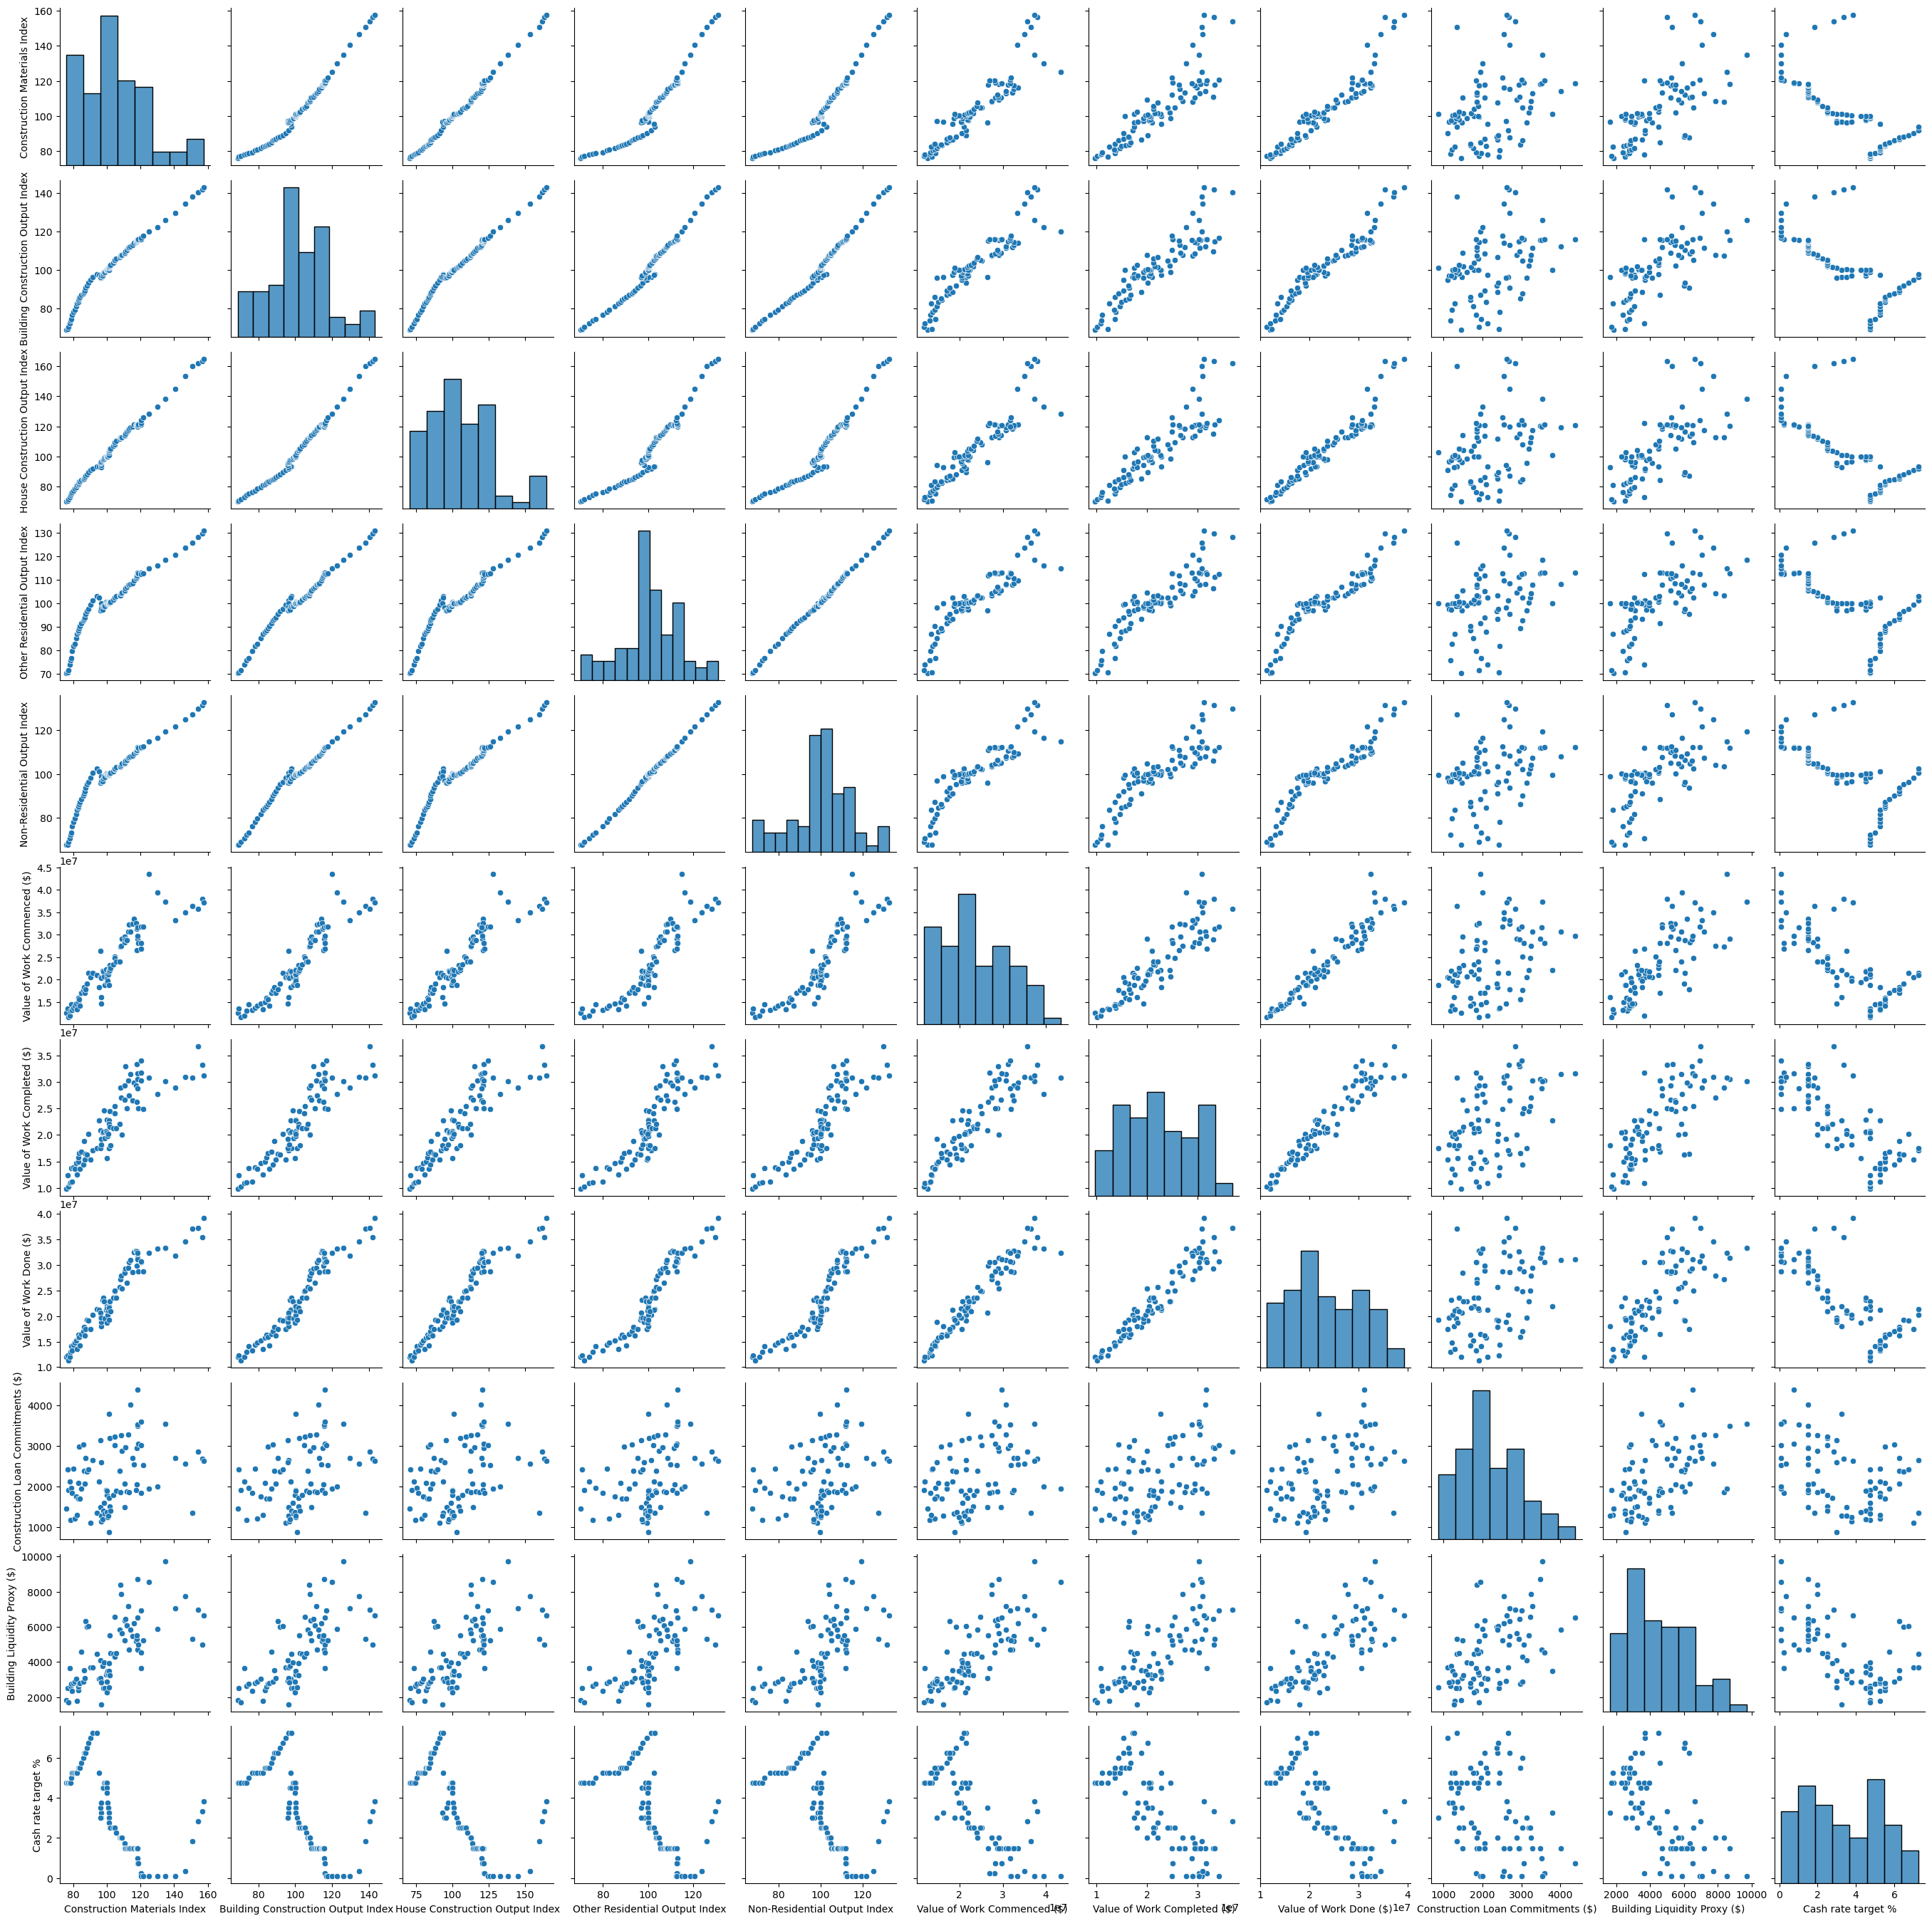

In [10]:
g = sns.PairGrid(data=final_construction_df.drop(columns=['Date']))
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)

From the pariplot above, we can see that there are some level of positive correlation between construction loan commitments and the material indices, and value of work. With this, we can see that when loan commitments are higher, there is higher levels of work done which will be good for the banks to use the building as collateral. 

Besides collateral challenges, we can see a slight negative correlation between the construction loan commitments and the cash rate target. Despite being small in terms of correlation, this can be used as a sign that during higher interest rates, the risk to loan money to a construction project is higher as we can see that higher rates do indicate lower levels of work done. This will then be challenging to the bank when the borrower defaults on their loans, as borrowing money inherently creates leverage and non-linearity for the borrower.

Looking at the Building Liquidity Proxy, we can also see similar relationships as the construction loan commitments with the material indices, and value of work. When building liquidity is higher, we can see that work done and materials will be higher too. 

The liquidity proxy can also show how and when the borrowers are able to sell the property at the event when the property is completed and the borrower defaults. We can see that liquidity for the buildings drop during higher levels of interest rates which will introduces a liquidity challenge for the bank.

## Data Extraction and Analysis for Illquid Stock

In [11]:
PERIOD_START = "2017-01-01"
PERIOD_END = "2024-01-01"

In [19]:
def extract_and_process_stocks() -> pd.DataFrame:

    stock = yf.Ticker(ILLIQUID_TICKER)
    stock_df = stock.history(start=PERIOD_START, end=PERIOD_END).reset_index()
    stock_df['Date'] = stock_df['Date'].dt.tz_localize(None)

    index = yf.Ticker(LIQUID_INDEX_TICKER)
    index_df = index.history(start=PERIOD_START, end=PERIOD_END).reset_index()
    index_df['Date'] = index_df['Date'].dt.tz_localize(None)
    index_df.head()

    vol_tracker = yf.Ticker(VOLATILITY_TRACKER)
    vol_df = vol_tracker.history(start=PERIOD_START, end=PERIOD_END).reset_index()
    vol_df = vol_df.rename(columns={col:f'{col}_{VOLATILITY_TRACKER}' for col in vol_df.columns.drop("Date")})
    vol_df['Date'] = vol_df['Date'].dt.tz_localize(None)
    vol_df.head()

    fed_rate = get_fred_data(param_list=[FRED], start_date=PERIOD_START, end_date=PERIOD_END)
    fed_rate_df = pd.DataFrame(columns=['Date'])
    fed_rate_df['Date'] = pd.date_range(PERIOD_START, PERIOD_END, freq='D')
    fed_rate_df = pd.merge(fed_rate_df, fed_rate, how='left', left_on='Date', right_on='DATE').drop(columns=['DATE']).ffill()
    fed_rate_df['FEDFUNDS'] = fed_rate_df['FEDFUNDS'].apply(np.floor)

    return pd.merge(pd.merge(pd.merge(stock_df, index_df, how='inner', on='Date', suffixes=[f"_{ILLIQUID_TICKER}", f"_{LIQUID_INDEX_TICKER}"]), fed_rate_df, on="Date"), vol_df, on="Date")

In [20]:
final_df = extract_and_process_stocks()
final_df.tail(10)

,Date,Open_KELYB,High_KELYB,Low_KELYB,Close_KELYB,Volume_KELYB,Dividends_KELYB,Stock Splits_KELYB,Open_SPY,High_SPY,...,Stock Splits_SPY,Capital Gains,FEDFUNDS,Open_^VIX,High_^VIX,Low_^VIX,Close_^VIX,Volume_^VIX,Dividends_^VIX,Stock Splits_^VIX
1750,2023-12-15,20.90,20.90,20.90,20.90,100,0.0,0.0,469.489990,470.700012,...,0.0,0.0,5.0,12.12,12.54,12.01,12.28,0,0.0,0.0
1751,2023-12-18,20.90,20.90,20.90,20.90,0,0.0,0.0,470.980011,472.980011,...,0.0,0.0,5.0,12.62,12.64,12.40,12.56,0,0.0,0.0
1752,2023-12-19,20.90,20.90,20.90,20.90,0,0.0,0.0,472.529999,474.920013,...,0.0,0.0,5.0,12.60,12.60,12.33,12.53,0,0.0,0.0
1753,2023-12-20,20.90,20.90,20.90,20.90,0,0.0,0.0,473.959991,475.899994,...,0.0,0.0,5.0,12.63,13.93,12.29,13.67,0,0.0,0.0
1754,2023-12-21,21.15,21.15,21.15,21.15,100,0.0,0.0,471.329987,472.980011,...,0.0,0.0,5.0,13.40,14.49,13.34,13.65,0,0.0,0.0
1755,2023-12-22,21.65,21.65,21.65,21.65,200,0.0,0.0,473.859985,475.380005,...,0.0,0.0,5.0,13.72,13.96,13.00,13.03,0,0.0,0.0
1756,2023-12-26,21.65,21.65,21.65,21.65,0,0.0,0.0,474.070007,476.579987,...,0.0,0.0,5.0,13.77,13.80,12.96,12.99,0,0.0,0.0
1757,2023-12-27,21.65,21.65,21.65,21.65,0,0.0,0.0,475.440002,476.660004,...,0.0,0.0,5.0,13.02,13.04,12.37,12.43,0,0.0,0.0
1758,2023-12-28,21.65,21.65,21.65,21.65,0,0.0,0.0,476.880005,477.549988,...,0.0,0.0,5.0,12.44,12.65,12.38,12.47,0,0.0,0.0
1759,2023-12-29,21.65,21.65,21.65,21.65,0,0.0,0.0,476.489990,477.029999,...,0.0,0.0,5.0,12.55,13.19,12.36,12.45,0,0.0,0.0


### Analysis of volatility and liquidity

/var/folders/p0/pbqvxybs0lg7lb7xzx1n1m440000gn/T/ipykernel_94163/1486942583.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vol_return[f'Volume_{LIQUID_INDEX_TICKER}'] = np.log10(vol_return[f'Volume_{LIQUID_INDEX_TICKER}'] + 1)
/var/folders/p0/pbqvxybs0lg7lb7xzx1n1m440000gn/T/ipykernel_94163/1486942583.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vol_return[f'Volume_{ILLIQUID_TICKER}'] = np.log10(vol_return[f'Volume_{ILLIQUID_TICKER}'] + 1)


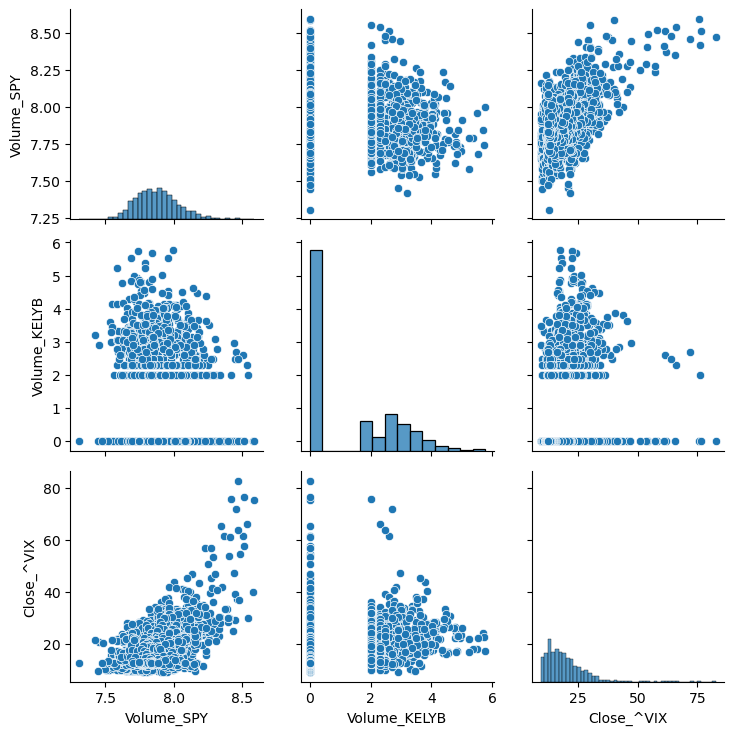

In [23]:
vol_return = final_df[[f'Volume_{LIQUID_INDEX_TICKER}', f'Volume_{ILLIQUID_TICKER}', f'Close_{VOLATILITY_TRACKER}']]
vol_return[f'Volume_{LIQUID_INDEX_TICKER}'] = np.log10(vol_return[f'Volume_{LIQUID_INDEX_TICKER}'] + 1)
vol_return[f'Volume_{ILLIQUID_TICKER}'] = np.log10(vol_return[f'Volume_{ILLIQUID_TICKER}'] + 1)
g = sns.PairGrid(data=vol_return)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)

From the above scatter plots, we can see that a lower level of trading volume of the illiquid stock when the closing values of the volatility index in higher. This indicates that when volatilty increases, we see a drop in trading volume of the illiquid stock. This would introduce the liquidity risk for the bank.

/var/folders/p0/pbqvxybs0lg7lb7xzx1n1m440000gn/T/ipykernel_94163/398307554.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  illiquid_vol[f'Volume_{ILLIQUID_TICKER}'] = np.log10(illiquid_vol[f'Volume_{ILLIQUID_TICKER}'] + 1)


<Figure size 2000x2000 with 0 Axes>

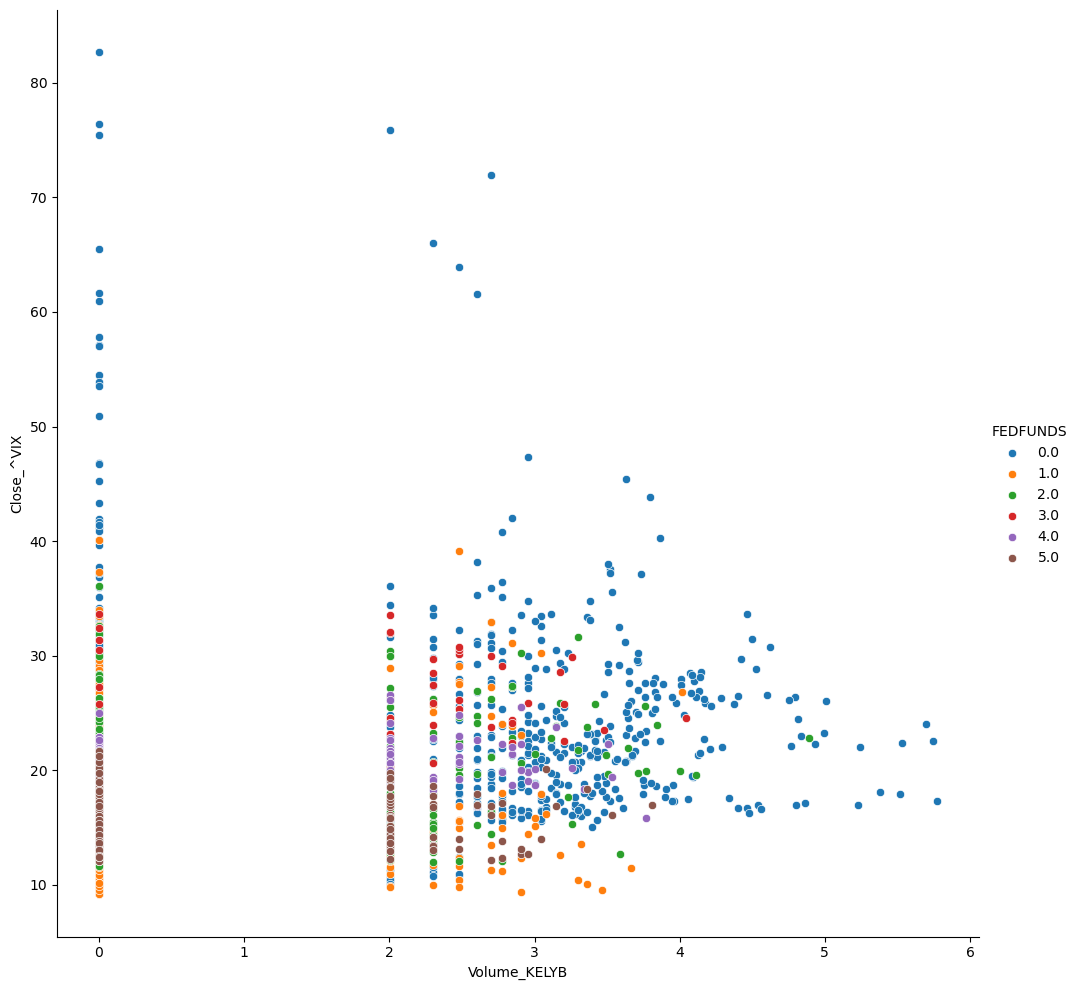

In [27]:
illiquid_vol = final_df[[f'Volume_{ILLIQUID_TICKER}', 'FEDFUNDS', f'Close_{VOLATILITY_TRACKER}']]
illiquid_vol[f'Volume_{ILLIQUID_TICKER}'] = np.log10(illiquid_vol[f'Volume_{ILLIQUID_TICKER}'] + 1)
plt.figure(figsize=(20, 20))
g = sns.FacetGrid(data=illiquid_vol, hue='FEDFUNDS', height=10, aspect=1)
g.map(sns.scatterplot, f'Volume_{ILLIQUID_TICKER}', f'Close_{VOLATILITY_TRACKER}')
g.add_legend()

Observing the plot above, we can see that the volume and closing values of the index is affected by the interest rates. With higher levels of interest rates, we can see that the volume is affected and the volatility index is low too. When the interests are low, we are able to observe a more volaitle trading volume, and the volatility index tend to be higher. This informs the lender regarding relationships of liquidity of the security with the volatility index and interest rates. 